# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")
print(Path.cwd().name)

c:\Users\cyber\OneDrive\Desktop\bakisanlan\github_repos\FeatureMatchingJUSTCODE\FeatureMatching-PythonCODE\LightGlue


fatal: destination path 'LightGlue' already exists and is not an empty directory.
c:\Users\cyber\OneDrive\Desktop\bakisanlan\github_repos\FeatureMatchingJUSTCODE\FeatureMatching-PythonCODE\LightGlue\lightglue\lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


LightGlue


In [2]:
def findParticlesKeypointDescriptors(particlesPxPos,yaw = 0, snapDim = (256,256), keypointBase_np = None, featuresBase = None, detector = 'SP', device = 'cuda'):
    """
    Filters ORB keypoints and descriptors that lie within a rotated rectangle.
    
    Parameters:
    - keypoints: List of cv2.KeyPoint objects.
    - descriptors: numpy array of shape (N, D), corresponding descriptors.
    - rect_center: tuple (x_c, y_c), center of the rectangle.
    - rect_size: tuple (w, h), dimensions of the rectangle (width, height).
    - angle: float, rotation angle of the rectangle in degrees (counterclockwise).

    Returns:
    - filtered_keypoints: List of cv2.KeyPoint objects inside the rectangle.
    - filtered_descriptors: numpy array of descriptors corresponding to those keypoints.
    """
    # Convert cv2.KeyPoint objects to NumPy array of coordinates
    
    # Convert from NED world frame to px(u,v)
    # particlesWorldPos NX2 array
    
    w, h = snapDim

    # N = particlesPxPos.shape[0]

    # Find min-max x,y in particles
    min_x = particlesPxPos[0].min() - (w // 2)
    max_x = particlesPxPos[0].max() + (w // 2)
    min_y = particlesPxPos[1].min() - (h // 2)
    max_y = particlesPxPos[1].max() + (h // 2)
    
    reduced_mask = (
                    (keypointBase_np[:, 0] <= max_x) & (keypointBase_np[:, 0] >= min_x) &
                    (keypointBase_np[:, 1] <= max_y) & (keypointBase_np[:, 1] >= min_y)
                    )
    
    # aug_keypoints_np = [kp for kp, mask in zip(keypoints_np, reduced_mask) if mask]
    reduced_keypoints = keypointBase_np[reduced_mask]
    if detector == 'ORB':
        reduced_descriptors = featuresBase[reduced_mask]
    elif detector == 'SP':
        keypoints, keypoint_scores, descriptors, image_size = featuresBase["keypoints"][:,reduced_mask,:] , featuresBase["keypoint_scores"][:,reduced_mask], featuresBase["descriptors"][:,reduced_mask,:] , featuresBase["image_size"]
        image_size = torch.from_numpy(np.array([w,h])[np.newaxis, : ]).to(device)
        # reduced_descriptors = {"keypoints" : keypoints, "keypoint_scores" : keypoint_scores, "descriptors" : descriptors , "image_size" : image_size}
        
        # scales, oris =  featuresBase["scales"][:,reduced_mask] , featuresBase["oris"][:,reduced_mask]
        # keypoints = keypoints - torch.from_numpy(np.array([min_x , min_y])[np.newaxis, : ]).to(device)
        reduced_descriptors = {"keypoints" : keypoints, "keypoint_scores" : keypoint_scores, "descriptors" : descriptors , "image_size" : image_size}#, "scales" : scales, "oris" : oris}
        
        
    # ParticlesKeypoints      = []
    # ParticlesDescriptors    = []
    # ParticlesLocalKeypoints = []

    # with Timer('dd'):
    # for i in range(N):
    # yaw = particlesYaw[i]  # rad
    # Compute rotation matrix
    R = np.array([
        [ np.cos(yaw),  np.sin(yaw)],
        [-np.sin(yaw),  np.cos(yaw)]
    ])

    # Shift keypoints to rectangle's center
    shifted_keypoints = reduced_keypoints - particlesPxPos

    # Rotate keypoints to rectangle's local frame
    local_keypoints = np.dot(shifted_keypoints, R) 
            
    inside_mask = (
        (np.abs(local_keypoints[:, 0]) <= w // 2) &
        (np.abs(local_keypoints[:, 1]) <= h // 2)
    )
    
    # Mask inside features
    particle_keypoint        = reduced_keypoints[inside_mask]
    particle_local_keyppoint = local_keypoints[inside_mask]  + np.array([ w // 2, h // 2])    # Particles Local Keypoints (relative keypoints  to uppler left corner of particles px)
    if detector == 'ORB':
        particle_descriptor = reduced_descriptors[inside_mask]
    elif detector == 'SP':
        keypoints, keypoint_scores, descriptors, image_size = reduced_descriptors["keypoints"][:,inside_mask,:] , reduced_descriptors["keypoint_scores"][:,inside_mask], reduced_descriptors["descriptors"][:,inside_mask,:] , reduced_descriptors["image_size"]
        # print(w,h)
        image_size = torch.from_numpy(np.array([w,h])[np.newaxis, : ]).to(device)
        # particle_descriptor = {"keypoints" : keypoints, "keypoint_scores" : keypoint_scores, "descriptors" : descriptors , "image_size" : image_size}

        # scales, oris =  reduced_descriptors["scales"][:,inside_mask] , reduced_descriptors["oris"][:,inside_mask]
        particle_descriptor = {"keypoints" : keypoints, "keypoint_scores" : keypoint_scores, "descriptors" : descriptors , "image_size" : image_size}#, "scales" : scales, "oris" : oris}
        
    # ParticlesKeypoints.append(particle_keypoint)
    # ParticlesDescriptors.append(particle_descriptor)
    # ParticlesLocalKeypoints.append(particle_local_keyppoint)
                
    return particle_local_keyppoint,particle_keypoint,particle_descriptor

## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [3]:
import torch
from lightglue import LightGlue, SIFT, ALIKED
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

# extractor = SuperPoint(max_num_keypoints=None).eval().to(device)  # load the extractor
extractor = SuperPoint(max_num_keypoints=2048, detection_threshold=0.0).eval().to(device)  # load the extractor
match_conf = {
    'width_confidence': -1,  # for point pruning
    'depth_confidence': -1,  # for early stopping,
    'flash': False,
}
# matcher = matcher = LightGlue(features='superpoint', depth_confidence=0.9, width_confidence=0.95).eval().cuda()
matcher = LightGlue(features='superpoint', **match_conf).eval().to(device)





In [4]:
import pickle
# from utils import drawKeypoints
import cv2 as cv
import numpy as np
import os
from time import time


## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

In [6]:
# image0 = load_image("C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingPYTHON/data/itu_map_square.jpg")
# image1 = load_image("C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingPYTHON/data/itu_map_square.jpg")

# feats0 = extractor.extract(image0.to(device))
# print(feats0["scales"].shape)
# feats1 = extractor.extract(image1.to(device))


# image0 = load_image('C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingPYTHON/data/cyclegan/turbo/winterUAV2summerSAT_test/real_sat_asvideo/sat_1800.jpg')
image0 = load_image('C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingPYTHON/data/cyclegan/turbo/winterUAV2summerSAT_test/v2/fid-16251/samples_a2b/103.png')
# image0 = load_image('C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingPYTHON/data/cyclegan/turbo/winterUAV2summerSAT_test/v1/fid_reference_b2a/frame_2160.png')
# image0 = load_image('C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingPYTHON/data/cyclegan/turbo/winterUAV2summerSAT_test/v1/fid_reference_b2a/frame_1800.png')


feats0_org = extractor.extract(image0.to(device))
print(feats0_org["keypoints"].shape)
n = feats0_org["keypoints"].shape[1]
perm = np.random.permutation(n)    # O(m)
feats0_org["keypoints"] = feats0_org["keypoints"][:,perm,:]
feats0_org["keypoint_scores"] = feats0_org["keypoint_scores"][:,perm]
feats0_org["descriptors"] = feats0_org["descriptors"][:,perm,:]



image1 = load_image("C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/data/itu_sat.jpg")

with open('C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/data/feature_map/SP/256/2048/descriptors.pkl', 'rb') as f:
    feats_base = pickle.load(f)  
with open('C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/data/feature_map/SP/256/2048/keypoints_np.pkl', 'rb') as f:
    keypointBase_np = pickle.load(f)  

particle_local_keyppoint,particle_keypoint,feats1_org = findParticlesKeypointDescriptors(np.array([2848+128,3450+128]),yaw = 0, snapDim = (220,220), keypointBase_np = keypointBase_np, featuresBase = feats_base)
print(feats1_org["keypoints"].shape)
# feats1_org["image_size"] = torch.from_numpy(np.array([200,200])[np.newaxis, : ]).to(device)

matches01 = matcher({"image0": feats0_org, "image1": feats1_org})
# print(feats0["keypoints"].shape)
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0_org, feats1_org, matches01]
]  # remove batch dimension
# print(image0.shape)

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]


# axes = viz2d.plot_images([image0, image1])
# viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
# viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

# kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
# viz2d.plot_images([image0, image1])
# viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
print(len(m_kpts0))
# print(m_kpts1)



# n = 50
# for key in feats0.keys():
#     feats0[key] = torch.cat([feats0[key]] * n)
#     feats1[key] = torch.cat([feats1[key]] * n)

# for i in range(10):
#     last_time=time()
#     with torch.inference_mode():
#         pred1 = matcher({'image0': feats0, 'image1': feats1})
#     current_time=time()
#     print(current_time-last_time)    
    
    


torch.Size([1, 2048, 2])
220 220
torch.Size([1, 1194, 2])
231


In [24]:
matches01['scores'].cpu().numpy().shape

(231,)

In [26]:
np.sum(matches01['scores'].cpu().numpy()) / matches01['scores'].cpu().numpy().shape[0]

np.float32(0.44968498)

In [33]:
imageref = load_image("C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/20250505/frame_15.png")


image1 = load_image("C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/data/05052025/00001.jpg")
image2 = load_image("C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/data/05052025/00002.jpg")
image3 = load_image("C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/data/05052025/00003.jpg")
image4 = load_image("C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/data/05052025/00004.jpg")
image5 = load_image("C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/data/05052025/00005.jpg")


feats_ref = extractor.extract(imageref.to(device))
print(feats_ref["keypoints"].shape)

feats1 = extractor.extract(image1.to(device))
print(feats1["keypoints"].shape)

feats2 = extractor.extract(image2.to(device))
print(feats2["keypoints"].shape)

feats3 = extractor.extract(image3.to(device))
print(feats3["keypoints"].shape)

feats4 = extractor.extract(image4.to(device))
print(feats4["keypoints"].shape)

feats5 = extractor.extract(image5.to(device))
print(feats5["keypoints"].shape)


torch.Size([1, 2048, 2])
torch.Size([1, 2048, 2])
torch.Size([1, 2048, 2])
torch.Size([1, 2048, 2])
torch.Size([1, 2048, 2])
torch.Size([1, 2048, 2])


In [49]:
matches01 = matcher({"image0": feats_ref, "image1": feats1})
# print(feats0["keypoints"].shape)
feats_ref_rbd, feats1_rbd, matches01 = [
    rbd(x) for x in [feats_ref, feats1, matches01]]


matches02 = matcher({"image0": feats_ref, "image1": feats2})
# print(feats0["keypoints"].shape)
feats_ref_rbd, feats2_rbd, matches02 = [
    rbd(x) for x in [feats_ref, feats2, matches02]]

matches03 = matcher({"image0": feats_ref, "image1": feats3})
# print(feats0["keypoints"].shape)
feats_ref_rbd, feats3_rbd, matches03 = [
    rbd(x) for x in [feats_ref, feats3, matches03]]

matches04 = matcher({"image0": feats_ref, "image1": feats4})
# print(feats0["keypoints"].shape)
feats_ref_rbd, feats4_rbd, matches04 = [
    rbd(x) for x in [feats_ref, feats4, matches04]]

matches05 = matcher({"image0": feats_ref, "image1": feats5})
# print(feats0["keypoints"].shape)
feats_ref_rbd, feats5_rbd, matches05 = [
    rbd(x) for x in [feats_ref, feats5, matches05]]

In [62]:
matches02["matches"].shape[0]

442

In [63]:
ref = matches01["matches"].shape[0]
print(matches02["matches"].shape[0] / ref, matches03["matches"].shape[0] / ref, matches04["matches"].shape[0] / ref, matches05["matches"].shape[0] / ref)

ref = np.sum(matches01['scores'].cpu().numpy()) / matches01['scores'].cpu().numpy().shape[0]

print(np.sum(matches02['scores'].cpu().numpy()) / matches02['scores'].cpu().numpy().shape[0] / ref)


print(np.sum(matches03['scores'].cpu().numpy()) / matches03['scores'].cpu().numpy().shape[0] / ref)


print(np.sum(matches04['scores'].cpu().numpy()) / matches04['scores'].cpu().numpy().shape[0] / ref)


print(np.sum(matches05['scores'].cpu().numpy()) / matches05['scores'].cpu().numpy().shape[0] / ref)



0.6071428571428571 0.6744505494505495 0.7678571428571429 0.6840659340659341
1.034472
1.1240959
1.0320138
1.0035402


In [71]:
scores1 = matches01['scores'].cpu().numpy() 
# print(np.sum(scores1[scores1 > 0.9]) / scores1[scores1 > 0.9].shape[0])
ref = np.sum(scores1[scores1 > 0])


scores2 = matches02['scores'].cpu().numpy() 
print((np.sum(scores2[scores2 > 0]) / ref))

scores3 = matches03['scores'].cpu().numpy() 
print((np.sum(scores3[scores3 > 0]) / ref))

scores4 = matches04['scores'].cpu().numpy() 
print((np.sum(scores4[scores4 > 0]) / ref))

scores5 = matches05['scores'].cpu().numpy() 
print((np.sum(scores5[scores5 > 0]) / ref))

0.6280723
0.7581471
0.7924392
0.6864876


In [72]:
ref

np.float32(379.40945)

In [69]:
scores1 = matches01['scores'].cpu().numpy() 
# print((scores1[scores1 > 0.5].shape))
ref = scores1[scores1 > 0.4].shape[0]

scores2 = matches02['scores'].cpu().numpy() 
print((scores2[scores2 > 0.4].shape[0] / ref))

scores3 = matches03['scores'].cpu().numpy() 
print((scores3[scores3 > 0.4].shape[0] / ref))

scores4 = matches04['scores'].cpu().numpy() 
print((scores4[scores4 > 0.4].shape[0] / ref))

scores5 = matches05['scores'].cpu().numpy() 
print((scores5[scores5 > 0.4].shape[0] / ref))

0.6162046908315565
0.7121535181236673
0.7633262260127932
0.6652452025586354


In [51]:
print(np.sum(matches01['scores'].cpu().numpy()))

print(np.sum(matches02['scores'].cpu().numpy()))


print(np.sum(matches03['scores'].cpu().numpy()))


print(np.sum(matches04['scores'].cpu().numpy()))


print(np.sum(matches05['scores'].cpu().numpy()))

379.40945
238.29657
287.6482
300.65894
260.4599


In [57]:
with open('C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/data/feature_map/SP/450/2048/descriptors.pkl', 'rb') as f:
    feats_base = pickle.load(f)  
with open('C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/data/feature_map/SP/450/2048/keypoints_np.pkl', 'rb') as f:
    keypointBase_np = pickle.load(f)  
    
N = 400
ref = np.array([2768+250,3008+250])
snapDim = (500,500)
dist = 200

imageref = load_image("C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/20250505/frame_15.png")

feats_ref = extractor.extract(imageref.to(device))
print(feats_ref["keypoints"].shape)



feat_list = []
pos = []
metric = []
for i in range(N):
    particlesPxPos = ref + (np.random.rand(2) - 0.5) * 2 * dist  # Randomly generate particles around the reference point
    # yaw = np.random.uniform(0, 2 * np.pi)
    yaw = 0  # Fixed yaw for testing
    particle_local_keyppoint,particle_keypoint,feats1 = findParticlesKeypointDescriptors(particlesPxPos,yaw = yaw, snapDim = snapDim, keypointBase_np = keypointBase_np, featuresBase = feats_base)
    # print(feats1_org["keypoints"].shape)
    
    matches01 = matcher({"image0": feats_ref, "image1": feats1})
    # print(feats0["keypoints"].shape)
    feats_ref_rbd, feats1_rbd, matches01 = [
        rbd(x) for x in [feats_ref, feats1, matches01]]
    
    # m = np.sum(matches01['scores'].cpu().numpy()) / matches01['scores'].cpu().numpy().shape[0] 
    m = matches01['matches'].shape[0]
    

    
    feat_list.append(feats1_org)
    pos.append(particlesPxPos)
    metric.append(m)
    
    # print(particlesPxPos)
    


torch.Size([1, 2048, 2])


In [58]:
comb = result = np.column_stack((pos, metric))


In [79]:
import cv2
from plotter import combineFrame
sat_frame = cv2.imread('C:/Users/cyber/OneDrive/Desktop/bakisanlan/github_repos/FeatureMatchingJUSTCODE/FeatureMatching-PythonCODE/data/itu_sat.jpg')
sat_frame = cv2.cvtColor(sat_frame, cv2.COLOR_BGR2RGB)
frame = combineFrame(sat_frame, ref, None, comb, min_w= 1000)

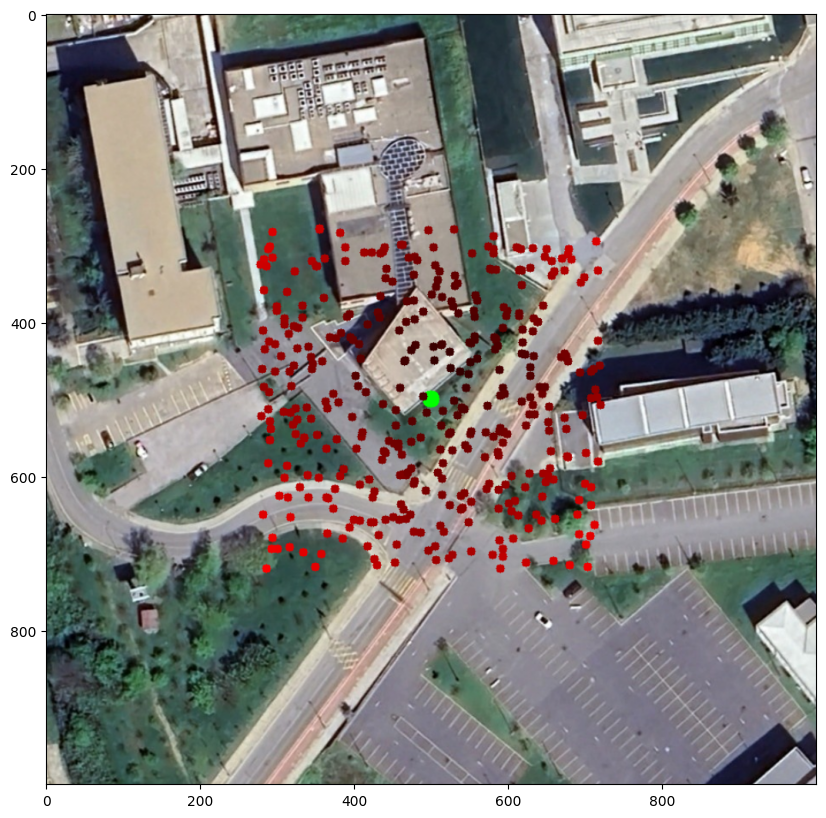

In [80]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 10))
plt.imshow(frame)

In [72]:
import sys
import os

# Go up one directory from current working directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from plotter import combineFrame

In [75]:
n_pad = abs(feats0["keypoints"].shape[0] - feats1["keypoints"].shape[0])
print(n_pad)

feat_willbe_padded = feats0_org.copy()
if feats0_org["keypoints"].shape[1] > feats1_org["keypoints"].shape[1]:
    feat_willbe_padded = feats1_org.copy()
    

# pad_kp    =  torch.ones((feat_willbe_padded["keypoints"].shape[0], n_pad, 2)).to(feat_willbe_padded["keypoints"].device)
pad_kp    =  -1*torch.ones((feat_willbe_padded["keypoints"].shape[0], n_pad, 2)).to(feat_willbe_padded["keypoints"].device)
# pad_desc  =  -torch.full((feat_willbe_padded["descriptors"].shape[0], n_pad, feat_willbe_padded["descriptors"].shape[2]),float('inf')).to(feat_willbe_padded["descriptors"].device)
pad_desc  =  -torch.ones((feat_willbe_padded["descriptors"].shape[0], n_pad, feat_willbe_padded["descriptors"].shape[2])).to(feat_willbe_padded["descriptors"].device) / 256
pad_score = torch.full((feat_willbe_padded["keypoint_scores"].shape[0], n_pad),float('inf')).to(feat_willbe_padded["keypoint_scores"].device)

feat_willbe_padded["keypoints"]       = torch.cat([feat_willbe_padded["keypoints"], pad_kp], dim=1)
feat_willbe_padded["descriptors"]     = torch.cat([feat_willbe_padded["descriptors"], pad_desc], dim=1) 
feat_willbe_padded["keypoint_scores"] = torch.cat([feat_willbe_padded["keypoint_scores"], pad_score], dim=1)


print(feat_willbe_padded["descriptors"].shape)


854
torch.Size([1, 2048, 256])


In [320]:
pad_desc

tensor([[[-0.0039, -0.0039, -0.0039,  ..., -0.0039, -0.0039, -0.0039],
         [-0.0039, -0.0039, -0.0039,  ..., -0.0039, -0.0039, -0.0039],
         [-0.0039, -0.0039, -0.0039,  ..., -0.0039, -0.0039, -0.0039],
         ...,
         [-0.0039, -0.0039, -0.0039,  ..., -0.0039, -0.0039, -0.0039],
         [-0.0039, -0.0039, -0.0039,  ..., -0.0039, -0.0039, -0.0039],
         [-0.0039, -0.0039, -0.0039,  ..., -0.0039, -0.0039, -0.0039]]],
       device='cuda:0')

print(feats0_org["keypoints"].shape)

In [76]:
matches01_2 = matcher({"image0": feats0_org, "image1": feat_willbe_padded})
# print(feats0["keypoints"].shape)
feats0_fix, feats1_fix, matches01_2 = [
    rbd(x) for x in [feats0_org, feat_willbe_padded, matches01_2]
]  # remove batch dimension
# print(image0.shape)

kpts0, kpts1, matches_2 = feats0_fix["keypoints"], feats1_fix["keypoints"], matches01_2["matches"]
m_kpts0, m_kpts1 = kpts0[matches_2[..., 0]], kpts1[matches_2[..., 1]]


# axes = viz2d.plot_images([image0, image1])
# viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
# viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

# kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
# viz2d.plot_images([image0, image1])
# viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
# print(len(m_kpts0.cpu().numpy()))

print(len(m_kpts0))


2


In [329]:
matches01_2

{'matches0': tensor([-1, -1, -1,  ..., -1, -1, -1], device='cuda:0'),
 'matches1': tensor([-1, -1, -1,  ..., -1, -1, -1], device='cuda:0'),
 'matching_scores0': tensor([0.0000, 0.0075, 0.0000,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'matching_scores1': tensor([0.0000, 0.0048, 0.0000,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'stop': 9,
 'matches': tensor([[286, 865],
         [487, 757]], device='cuda:0'),
 'scores': tensor([0.1205, 0.1021], device='cuda:0'),
 'prune0': tensor([9., 9., 9.,  ..., 9., 9., 9.], device='cuda:0'),
 'prune1': tensor([9., 9., 9.,  ..., 9., 9., 9.], device='cuda:0')}

In [119]:
print(len(m_kpts0))


0


In [68]:
a1 = matches.cpu().numpy()
a1.shape

(229, 2)

In [69]:
a2 = matches_2.cpu().numpy()
a2.shape

(1, 2)

In [70]:
a1_with_row = np.vstack([a1, np.zeros((2,2),dtype=int)])
a1_with_row.shape


(231, 2)

In [71]:
matches_2

tensor([[286, 865]], device='cuda:0')

In [72]:
np.hstack([a1_with_row,a2]) 

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 231 and the array at index 1 has size 1

In [5]:
def findParticlesKeypointDescriptors(particlesPxPos,yaw = 0, snapDim = (256,256), keypointBase_np = None, featuresBase = None, detector = 'SP', device = 'cuda'):
    """
    Filters ORB keypoints and descriptors that lie within a rotated rectangle.
    
    Parameters:
    - keypoints: List of cv2.KeyPoint objects.
    - descriptors: numpy array of shape (N, D), corresponding descriptors.
    - rect_center: tuple (x_c, y_c), center of the rectangle.
    - rect_size: tuple (w, h), dimensions of the rectangle (width, height).
    - angle: float, rotation angle of the rectangle in degrees (counterclockwise).

    Returns:
    - filtered_keypoints: List of cv2.KeyPoint objects inside the rectangle.
    - filtered_descriptors: numpy array of descriptors corresponding to those keypoints.
    """
    # Convert cv2.KeyPoint objects to NumPy array of coordinates
    
    # Convert from NED world frame to px(u,v)
    # particlesWorldPos NX2 array
    
    w, h = snapDim

    # N = particlesPxPos.shape[0]

    # Find min-max x,y in particles
    min_x = particlesPxPos[0].min() - (w // 2)
    max_x = particlesPxPos[0].max() + (w // 2)
    min_y = particlesPxPos[1].min() - (h // 2)
    max_y = particlesPxPos[1].max() + (h // 2)
    
    reduced_mask = (
                    (keypointBase_np[:, 0] <= max_x) & (keypointBase_np[:, 0] >= min_x) &
                    (keypointBase_np[:, 1] <= max_y) & (keypointBase_np[:, 1] >= min_y)
                    )
    
    # aug_keypoints_np = [kp for kp, mask in zip(keypoints_np, reduced_mask) if mask]
    reduced_keypoints = keypointBase_np[reduced_mask]
    if detector == 'ORB':
        reduced_descriptors = featuresBase[reduced_mask]
    elif detector == 'SP':
        keypoints, keypoint_scores, descriptors, image_size = featuresBase["keypoints"][:,reduced_mask,:] , featuresBase["keypoint_scores"][:,reduced_mask], featuresBase["descriptors"][:,reduced_mask,:] , featuresBase["image_size"]
        image_size = torch.from_numpy(np.array([w,h])[np.newaxis, : ]).to(device)
        # reduced_descriptors = {"keypoints" : keypoints, "keypoint_scores" : keypoint_scores, "descriptors" : descriptors , "image_size" : image_size}
        
        # scales, oris =  featuresBase["scales"][:,reduced_mask] , featuresBase["oris"][:,reduced_mask]
        reduced_descriptors = {"keypoints" : keypoints, "keypoint_scores" : keypoint_scores, "descriptors" : descriptors , "image_size" : image_size}#, "scales" : scales, "oris" : oris}
        
        
    # ParticlesKeypoints      = []
    # ParticlesDescriptors    = []
    # ParticlesLocalKeypoints = []

    # with Timer('dd'):
    # for i in range(N):
    # yaw = particlesYaw[i]  # rad
    # Compute rotation matrix
    R = np.array([
        [ np.cos(yaw),  np.sin(yaw)],
        [-np.sin(yaw),  np.cos(yaw)]
    ])

    # Shift keypoints to rectangle's center
    shifted_keypoints = reduced_keypoints - particlesPxPos

    # Rotate keypoints to rectangle's local frame
    local_keypoints = np.dot(shifted_keypoints, R) 
            
    inside_mask = (
        (np.abs(local_keypoints[:, 0]) <= w // 2) &
        (np.abs(local_keypoints[:, 1]) <= h // 2)
    )
    
    # Mask inside features
    particle_keypoint        = reduced_keypoints[inside_mask]
    particle_local_keyppoint = local_keypoints[inside_mask]  + np.array([ w // 2, h // 2])    # Particles Local Keypoints (relative keypoints  to uppler left corner of particles px)
    if detector == 'ORB':
        particle_descriptor = reduced_descriptors[inside_mask]
    elif detector == 'SP':
        keypoints, keypoint_scores, descriptors, image_size = reduced_descriptors["keypoints"][:,inside_mask,:] , reduced_descriptors["keypoint_scores"][:,inside_mask], reduced_descriptors["descriptors"][:,inside_mask,:] , reduced_descriptors["image_size"]
        image_size = torch.from_numpy(np.array([w,h])[np.newaxis, : ]).to(device)
        # particle_descriptor = {"keypoints" : keypoints, "keypoint_scores" : keypoint_scores, "descriptors" : descriptors , "image_size" : image_size}

        # scales, oris =  reduced_descriptors["scales"][:,inside_mask] , reduced_descriptors["oris"][:,inside_mask]
        particle_descriptor = {"keypoints" : keypoints, "keypoint_scores" : keypoint_scores, "descriptors" : descriptors , "image_size" : image_size}#, "scales" : scales, "oris" : oris}
        
    # ParticlesKeypoints.append(particle_keypoint)
    # ParticlesDescriptors.append(particle_descriptor)
    # ParticlesLocalKeypoints.append(particle_local_keyppoint)
                
    return particle_local_keyppoint,particle_keypoint,particle_descriptor

In [62]:
feats0['descriptors'].dtype

torch.float32

In [32]:
b = a.cpu().numpy().squeeze()

In [38]:
b_concat = np.hstack((b, b))
print(np.atleast_2d(b_concat).shape)

(1, 39286)


In [15]:
import numpy as np


In [97]:
import numpy as np
torch.from_numpy(np.array([1,2])[np.newaxis, : ]).to('cuda').shape

torch.Size([1, 2])

## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

In [119]:
image0 = load_image(images / "sacre_coeur1.jpg")
image1 = load_image(images / "sacre_coeur2.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})

feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension
print(matches01["matches"]).shape


kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

tensor([[  82, 1884],
        [ 106, 1124],
        [ 111,  332],
        [ 125, 1855],
        [ 134,  498],
        [ 169, 1511],
        [ 191, 1857],
        [ 197, 1968],
        [ 236,  492],
        [ 272,  438],
        [ 285,  826],
        [ 287,  436],
        [ 295,  144],
        [ 296, 1200],
        [ 300,   22],
        [ 306,   97],
        [ 307,  371],
        [ 311, 1163],
        [ 316,  217],
        [ 319,  783],
        [ 324, 1654],
        [ 325,  307],
        [ 326,  183],
        [ 330,   83],
        [ 334,  443],
        [ 335, 1171],
        [ 337,  473],
        [ 339,  846],
        [ 345,  559],
        [ 350,  541],
        [ 353,  655],
        [ 357, 1585],
        [ 358,  218],
        [ 364,  901],
        [ 365, 1667],
        [ 370, 1800],
        [ 372,  970],
        [ 373, 1938],
        [ 374, 1549],
        [ 375,  393],
        [ 376, 1177],
        [ 378, 1642],
        [ 390,  975],
        [ 391,  930],
        [ 397,  329],
        [ 

AttributeError: 'NoneType' object has no attribute 'shape'